In [1]:
import torch
#import tensorflow
import numpy as np 
import matplotlib.pyplot as plt
from statsmodels.multivariate.pca import PCA
import pandas as pd

In [2]:
#understanding how PCA works

X = np.asarray(
        [[None  , 200.0 , None  ],
         [   1.1, 100.4 ,    5.3],
         [   5.3, 100.5 ,    1.3],
         [None  , None  ,    1.9],
         [   1.2, 100.4 , None  ],
         [   2.3, 100.7 ,    2.4],
         [   1.6, None  ,    2.4],
         [None  , 100.8 , None  ]], dtype=np.float64)

X = np.asarray(
        [[None  , .1  , None  ],
         [   0.1, None, None  ],
         [   0.7, None, None  ],
         [None  , None,    .1 ],
         [None  , 0.4 , None  ],
         [   0.3, None, None  ],
         [None  , None,    0.4],
         [None  , 0.8 , None  ]], dtype=np.float64)

pc = PCA(data=X, ncomp=1, method='nipals', missing='fill-em') 
X_filled = pc._adjusted_data

print(X_filled)

C:\Users\klind\Anaconda3\lib\site-packages\statsmodels\multivariate\pca.py:504: RuntimeWarning: divide by zero encountered in double_scalars
  diff = _norm(delta) / _norm(projection_masked)
C:\Users\klind\Anaconda3\lib\site-packages\statsmodels\multivariate\pca.py:504: RuntimeWarning: invalid value encountered in double_scalars
  diff = _norm(delta) / _norm(projection_masked)


[[0.36666667 0.1        0.25      ]
 [0.1        0.43333333 0.25      ]
 [0.7        0.43333333 0.25      ]
 [0.36666667 0.43333333 0.1       ]
 [0.36666667 0.4        0.25      ]
 [0.3        0.43333333 0.25      ]
 [0.36666667 0.43333333 0.4       ]
 [0.36666667 0.8        0.25      ]]


In [3]:
allTimeSeries=torch.load("data/192T/time_series.pt")
allMasks=torch.load("data/192T/masks.pt")
allDiffs=torch.load("data/192T/diffs.pt")
allLabels=torch.load("data/192T/labels.pt")

In [4]:
def calculateGlobalMean(variableNum, allTimeSeries, allDiffs):
    meanForPatientArray=[]
    
    #CHANGE TO 6261 TO ITERATE OVER ALL PATIENTS
    numOfPatients=1000
    
    for i in range(numOfPatients):
        timeSeriesForPatientAndVariable = np.asarray(allTimeSeries[i, ... , variableNum])
        diffForPatientAndVariable = np.asarray(allDiffs[i, ..., variableNum])
        if (diffForPatientAndVariable[191]>=3.9791667):
            #print('patient ', i, ' does not have any observations for variable ', variableNum)
            pass
        else:
            meanForPatient = np.mean(timeSeriesForPatientAndVariable, dtype ='float64')
            meanForPatientArray.append(meanForPatient)
    
    
    if(len(meanForPatientArray)<(.05*6261)):     #if there are too few observations for this variable
        globalMean = 0.0                        
        #impute with zero because healthy ppl are not tested for this variable
        print('imputed with zeros')
        #print('length for meanForPatientsArray: ', len(meanForPatientArray))
    else:
        globalMean = np.mean(meanForPatientArray, dtype ='float64')
    
    return globalMean

In [5]:
#IMPUTATION WITH MEAN OF ENTIRE TIME SEREIS

def impute_PCA(allTimeSeries, allMasks, allDiffs):
    
    #CHANGE TO 6261 TO ITERATE OVER ALL PATIENTS' TIME SERIES
    numOfPatients = 2
    
    allTimeSeriesAfterImputingTensor = torch.zeros(size=(numOfPatients, 192, 58))
    allMasksAfterImputingTensor = torch.zeros(size=(numOfPatients, 192, 58))
    allDiffsAfterImputingTensor = torch.zeros(size=(numOfPatients, 192, 58))

    for i in range(1, numOfPatients):                         #6261 is num of patients
        
        perPatientTimeSeriesMatrix = np.zeros(shape=(192, 58))
        
        for j in range(59):                       #59 is num of variables
            
            if j==19:   
                #variable 19 (temperature) is unneccessray becuase it is same as variable 45 except it has more missing data
                pass
            
            else:
                oneTimeSeries = np.asarray(allTimeSeries[i, ..., j])
                oneMask = np.asarray(allMasks[i, ..., j])
                oneDiff = np.asarray(allDiffs[i, ..., j])
                print('patient num', i, 'variable number: ', j)
                realObservations = []                #vector with observed data values that are not outliers
                indexesOfRealObservations = []

                #fill up yVector with observed data values
                for k in range(192):
                    if (oneMask[k]==0.0):              #if datapoint is NOT originally missing
                        indexesOfRealObservations.append(k)
                        realObservations.append(oneTimeSeries[k])

                #calculating mean, standard deviation, bounds for outliers
                mean = np.mean(realObservations)
                sd = np.std(realObservations)
                upperBound = mean + 2*sd
                lowerBound = mean - 2*sd

                #finding outliers    
                indexesOfNoOutliersRealObservations = []
                noOutliersRealObservations = []
                for t in range(len(realObservations)):
                    indexesOfNoOutliersRealObservations.append(indexesOfRealObservations[t])
                    noOutliersRealObservations.append(realObservations[t])
                for m in range(len(realObservations)):
                    if (realObservations[m] > upperBound or realObservations[m] < lowerBound):
                        #print('outlier tick')
                        indexOfOutlierInOriginalTS = indexesOfRealObservations[m]
                        #print('outlier index in original TS: ', indexOfOutlierInOriginalTS)
                        indexesOfNoOutliersRealObservations.remove(indexOfOutlierInOriginalTS)
                        noOutliersRealObservations.remove(realObservations[m])
                    else:    #if this real observation is not an outlier
                        pass 
                
                #imputing time series outliers and missing values with values determined by PCA, masks with 1.0, diffs with 0.0 
                if len(indexesOfRealObservations)==0:
                    globalMean=calculateGlobalMean(j, allTimeSeries, allDiffs)
                    oneTimeSeries.fill(globalMean)
                else:
                    #change outliers, missing values from zeros to None's/NaN
                    for n in range(192):
                        if (n not in indexesOfNoOutliersRealObservations):    #if oneTimeSereis[n] is outlier or missing
                            oneTimeSeries[n] = None
                            oneMask[n] = 1.0
                            if n==0:
                                oneDiff[n] = 0.0
                            else:
                                oneDiff[n] = oneDiff[n-1] + (1/48)
                        else:                                                 #if it is not outlier or missing
                            oneDiff[n] = 0.0
                
            #putting mask, diffs vectors in original tensor shapes
            if(j<19):
                perPatientTimeSeriesMatrix[...,j] = (oneTimeSeries.T)
                allMasksAfterImputingTensor[i, ..., j] = torch.from_numpy(np.asarray(oneMask))
                allDiffsAfterImputingTensor[i, ..., j] = torch.from_numpy(np.asarray(oneDiff))
            else:
                perPatientTimeSeriesMatrix[...,j-1] = (oneTimeSeries.T)
                allMasksAfterImputingTensor[i, ..., j-1] = torch.from_numpy(np.asarray(oneMask))
                allDiffsAfterImputingTensor[i, ..., j-1] = torch.from_numpy(np.asarray(oneDiff))
                
        #applying PCA to matrix for each patient (192 x 58)
        perPatientTimeSeriesMatrix = perPatientTimeSeriesMatrix[100:150, 13:17] #break up large matrix into smaller pieces for testing
        print('perPatientTimeSeriesMatrix: ', perPatientTimeSeriesMatrix)
        pc = PCA(data=perPatientTimeSeriesMatrix, ncomp=1, method='nipals', missing='fill-em') 
        perPatientFilledMatrix = pc._adjusted_data
        
        #putting time series vectors in original tensor shapes
        print('perPatientFilledMatrix: ', perPatientFilledMatrix)
        allTimeSeriesAfterImputingTensor[i, ..., ...] = torch.from_numpy(perPatientFilledMatrix)
        

    return allTimeSeriesAfterImputingTensor, allMasksAfterImputingTensor, allDiffsAfterImputingTensor

In [6]:
out1, out2, out3 = impute_PCA(allTimeSeries, allMasks, allDiffs)

patient num 1 variable number:  0


C:\Users\klind\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\klind\Anaconda3\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
C:\Users\klind\Anaconda3\lib\site-packages\numpy\core\_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
C:\Users\klind\Anaconda3\lib\site-packages\numpy\core\_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
C:\Users\klind\Anaconda3\lib\site-packages\numpy\core\_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


imputed with zeros
patient num 1 variable number:  1
imputed with zeros
patient num 1 variable number:  2
imputed with zeros
patient num 1 variable number:  3
imputed with zeros
patient num 1 variable number:  4
imputed with zeros
patient num 1 variable number:  5
imputed with zeros
patient num 1 variable number:  6
imputed with zeros
patient num 1 variable number:  7
imputed with zeros
patient num 1 variable number:  8
imputed with zeros
patient num 1 variable number:  9
imputed with zeros
patient num 1 variable number:  10
imputed with zeros
patient num 1 variable number:  11
patient num 1 variable number:  12
imputed with zeros
patient num 1 variable number:  13
imputed with zeros
patient num 1 variable number:  14
patient num 1 variable number:  15
patient num 1 variable number:  16
patient num 1 variable number:  17
patient num 1 variable number:  18
patient num 1 variable number:  20
patient num 1 variable number:  21
patient num 1 variable number:  22
patient num 1 variable numb

C:\Users\klind\Anaconda3\lib\site-packages\statsmodels\multivariate\pca.py:405: RuntimeWarning: invalid value encountered in true_divide
  data = (adj_data - self._mu) / self._sigma
C:\Users\klind\Anaconda3\lib\site-packages\statsmodels\multivariate\pca.py:482: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(data, 0)
C:\Users\klind\Anaconda3\lib\site-packages\statsmodels\multivariate\pca.py:523: RuntimeWarning: invalid value encountered in less_equal
  if (vals <= 0).any():
C:\Users\klind\Anaconda3\lib\site-packages\statsmodels\multivariate\pca.py:402: RuntimeWarning: Mean of empty slice
  self._mu = np.nanmean(adj_data, axis=0)
C:\Users\klind\Anaconda3\lib\site-packages\statsmodels\multivariate\pca.py:403: RuntimeWarning: Mean of empty slice
  self._sigma = np.sqrt(np.nanmean((adj_data - self._mu) ** 2.0, axis=0))
C:\Users\klind\Anaconda3\lib\site-packages\statsmodels\multivariate\pca.py:570: RuntimeWarning: invalid value encountered in less_equal
  invalid = ess <= 0  # Prevent

perPatientFilledMatrix:  [[       nan        nan        nan        nan]
 [       nan        nan        nan        nan]
 [       nan        nan        nan        nan]
 [       nan        nan        nan        nan]
 [       nan        nan        nan        nan]
 [       nan        nan        nan        nan]
 [       nan        nan        nan        nan]
 [       nan        nan        nan        nan]
 [       nan        nan        nan        nan]
 [       nan        nan        nan        nan]
 [       nan        nan        nan        nan]
 [       nan        nan        nan        nan]
 [       nan        nan        nan        nan]
 [       nan        nan        nan        nan]
 [       nan        nan        nan        nan]
 [       nan 0.00470729        nan        nan]
 [       nan        nan        nan        nan]
 [       nan        nan        nan        nan]
 [       nan        nan        nan        nan]
 [       nan        nan        nan        nan]
 [       nan        nan        nan 

RuntimeError: The expanded size of the tensor (58) must match the existing size (4) at non-singleton dimension 1.  Target sizes: [192, 58].  Tensor sizes: [50, 4]

In [70]:
def plotPCAImputation(patient, timeSeriesTensor, masksTensor, diffsTensor):
    
    masksMatrix = np.asmatrix(masksTensor[patient, ..., ...])
    PCAImputedMatrix = timeSeriesTensor[patient, ..., ...]
    zeroImputedMatrix = np.zeros(shape=(192,58))
    for ts in range(len(PCAImputedMatrix[..., 1])):
        for var in range(len(PCAImputedMatrix[1, ...])):
            maskValue = masksMatrix[ts, var]
            if maskValue==0.0:         #not missing
                zeroImputedMatrix[ts, var]=PCAImputedMatrix[ts, var]
    
    for x in range(len(PCAImputedMatrix[..., 1])): 
        print('variable: ', x)
        PCAImputedTS = np.asarray(PCAImputedMatrix[...,x])
        zeroImputedTS = np.asarray(zeroImputedMatrix[...,x])
        
        timeStepVector = [s for s in range(len(zeroImputedTS))]

        #plotting timeseries, masks, and diffs
        plt.subplot(4,1,1)
        plt.plot(timeStepVector, zeroImputedTS)
        plt.title('Zero-Imputed Time Series')
        plt.ylabel('medical value')
        plt.xlabel('')

        plt.subplot(4,1,2)
        plt.plot(timeStepVector, PCAImputedTS)
        plt.title('PCA-Imputed Time Series')
        plt.ylabel('medical value')
        plt.xlabel('')

        plt.subplot(4,1,3)
        plt.scatter(timeStepVector, np.asarray(masksTensor[patient,...,x]), color="red", s=1)
        plt.title('Missing Data: boolean variable')
        plt.ylabel('1=missing')
        plt.axis([0, 200, -.092, 1.092])
        plt.xlabel('')

        plt.subplot(4,1,4)
        plt.scatter(timeStepVector, np.asarray(diffsTensor[patient,...,x]), c='green', s=1)
        plt.title('Time Step Difference Between Observations')
        plt.ylabel('count')
        plt.xlabel('time step')
        plt.tight_layout()
        plt.show()

variable:  0


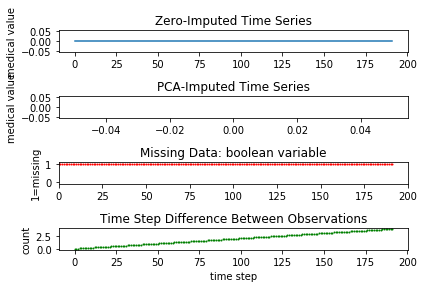

variable:  1


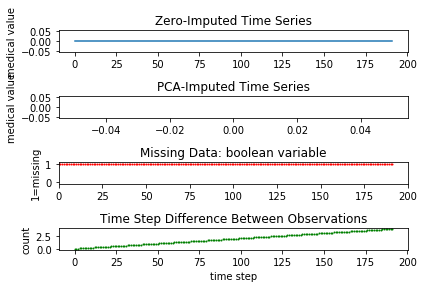

variable:  2


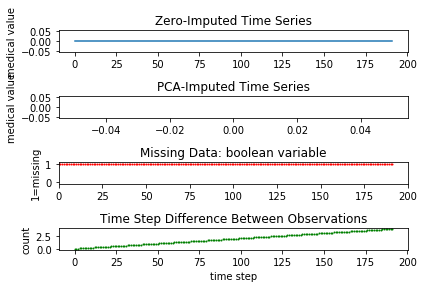

variable:  3


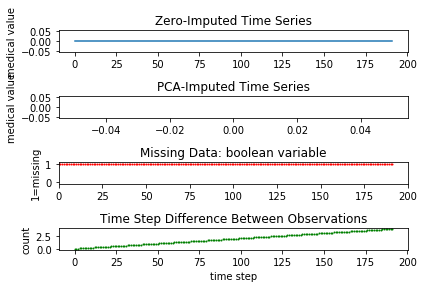

variable:  4


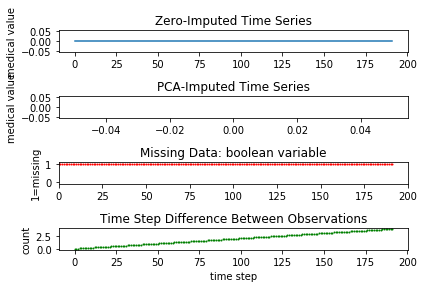

variable:  5


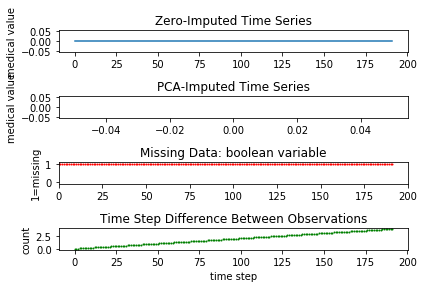

variable:  6


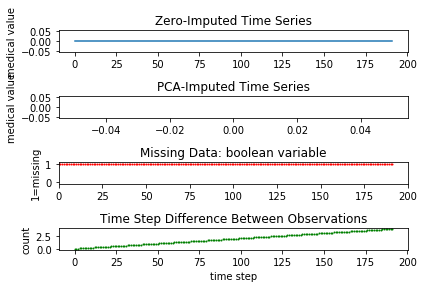

variable:  7


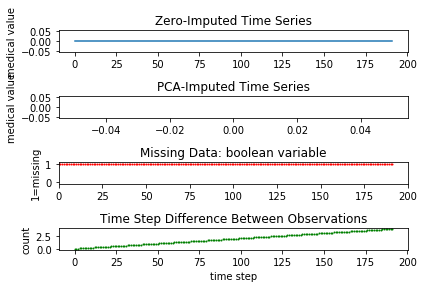

variable:  8


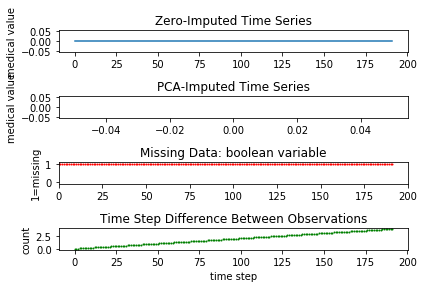

variable:  9


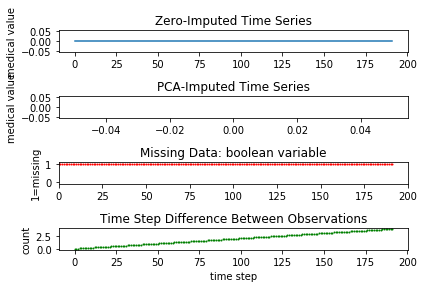

variable:  10


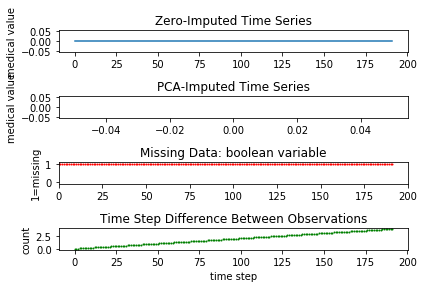

variable:  11


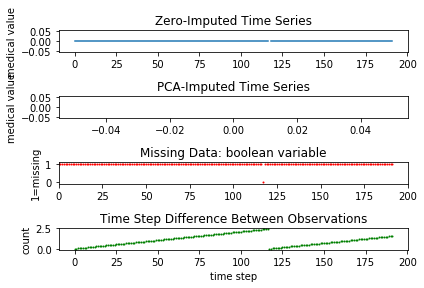

variable:  12


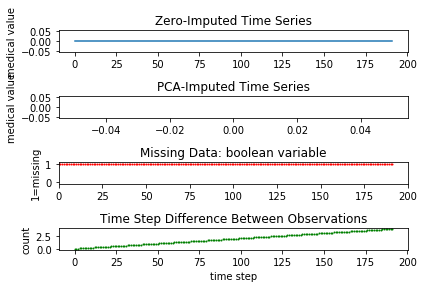

variable:  13


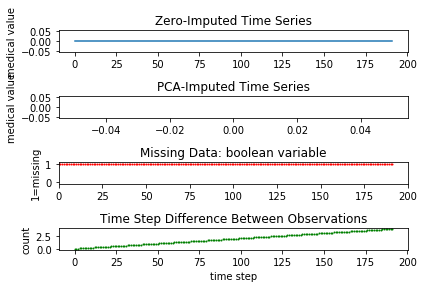

variable:  14


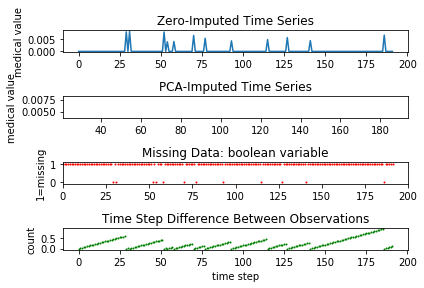

variable:  15


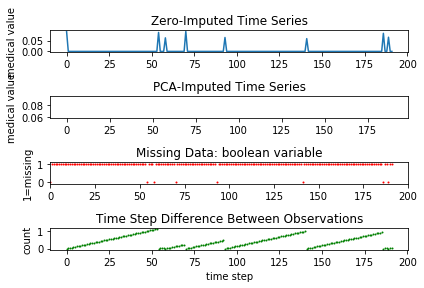

variable:  16


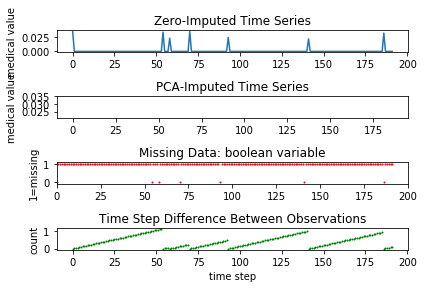

variable:  17


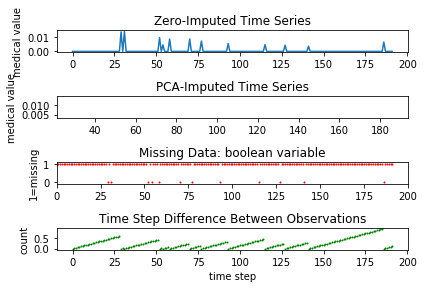

variable:  18


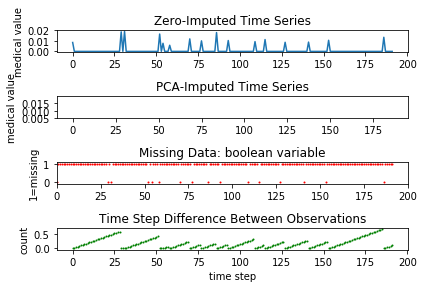

variable:  19


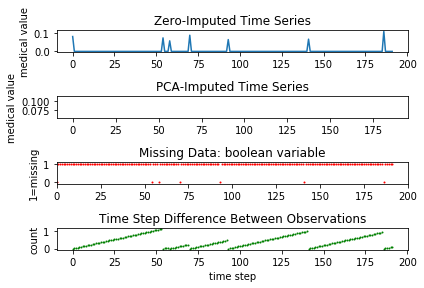

variable:  20


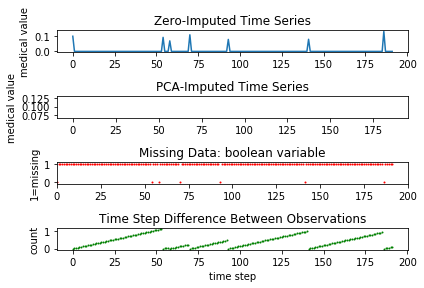

variable:  21


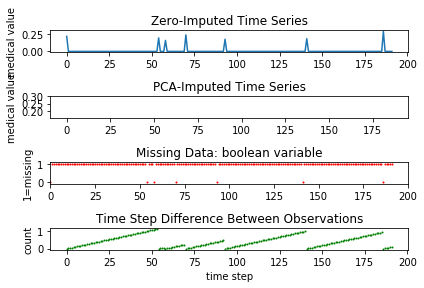

variable:  22


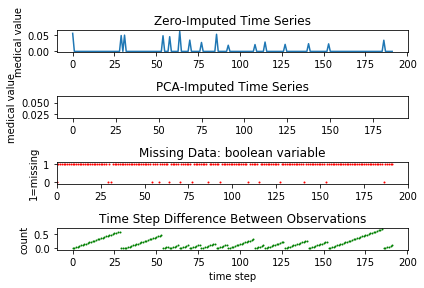

variable:  23


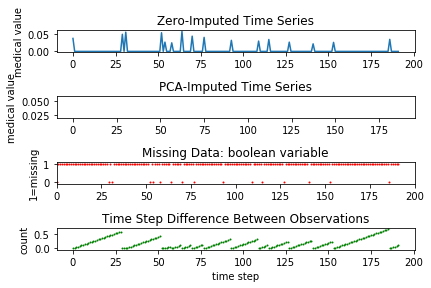

variable:  24


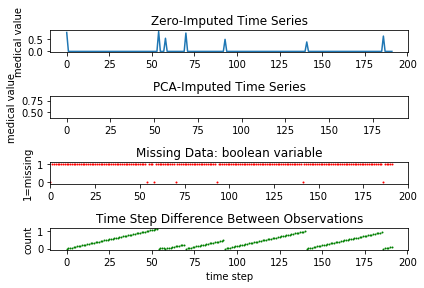

variable:  25


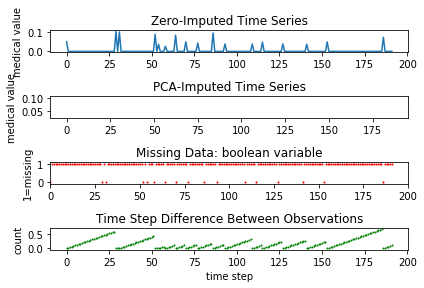

variable:  26


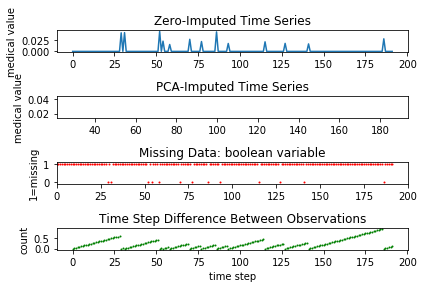

variable:  27


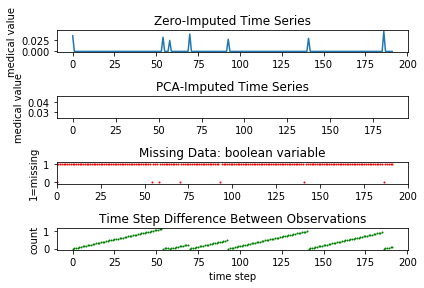

variable:  28


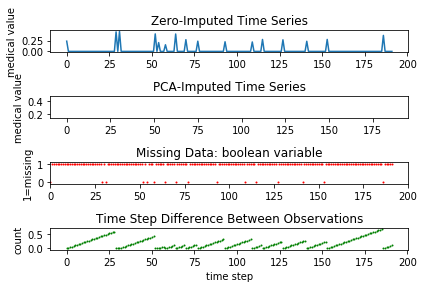

variable:  29


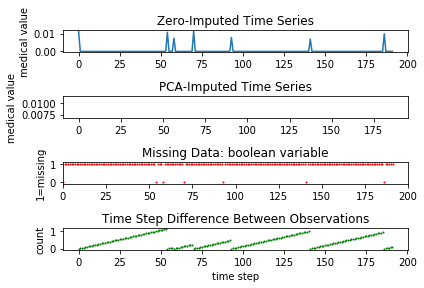

variable:  30


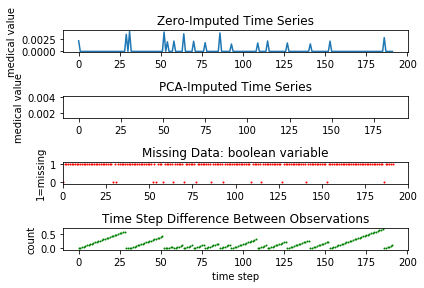

variable:  31


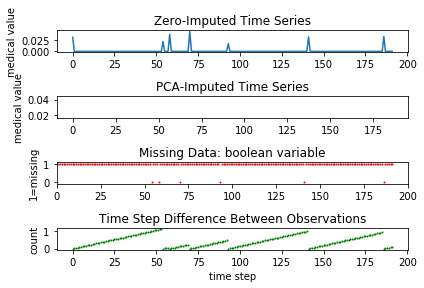

variable:  32


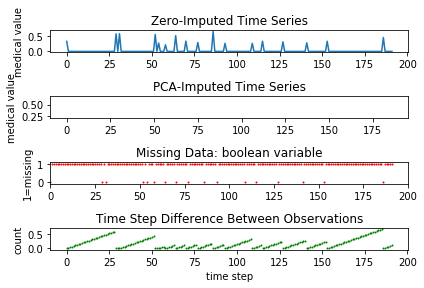

variable:  33


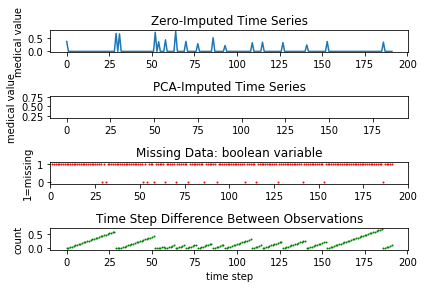

variable:  34


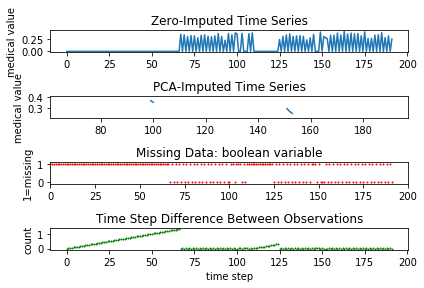

variable:  35


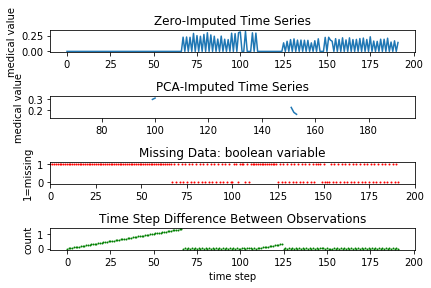

variable:  36


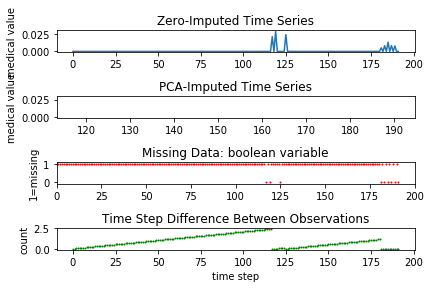

variable:  37


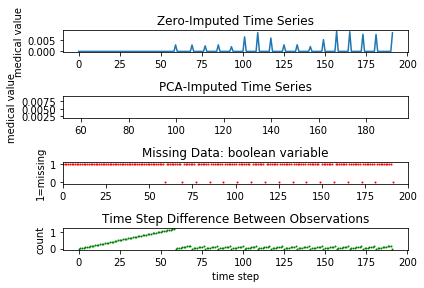

variable:  38


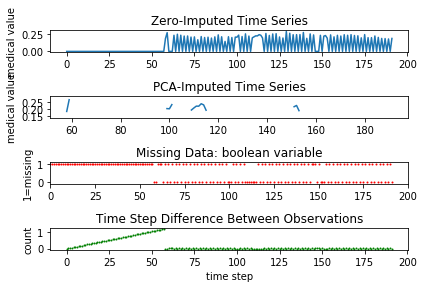

variable:  39


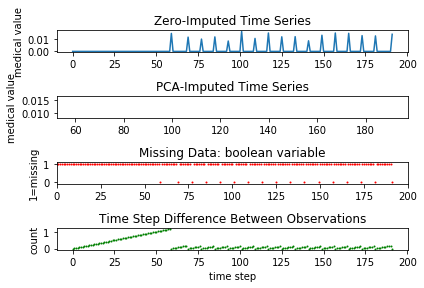

variable:  40


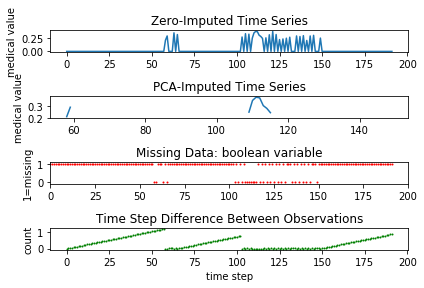

variable:  41


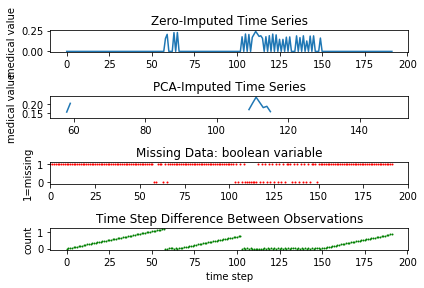

variable:  42


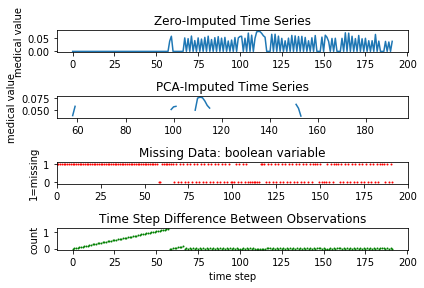

variable:  43


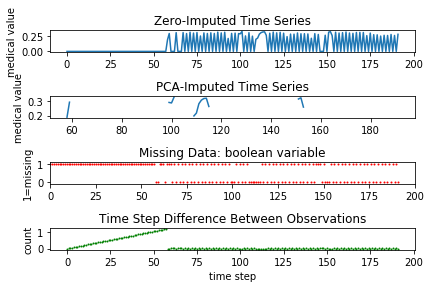

variable:  44


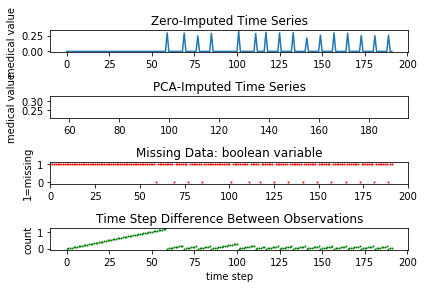

variable:  45


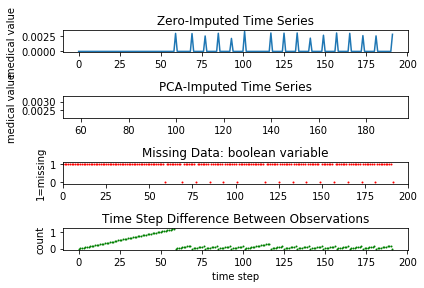

variable:  46


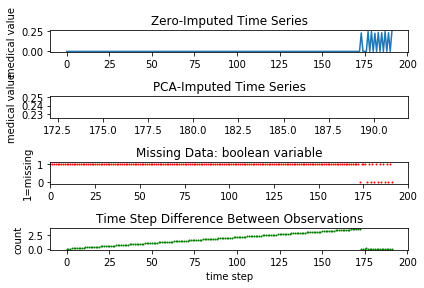

variable:  47


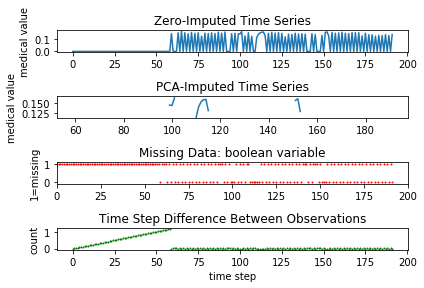

variable:  48


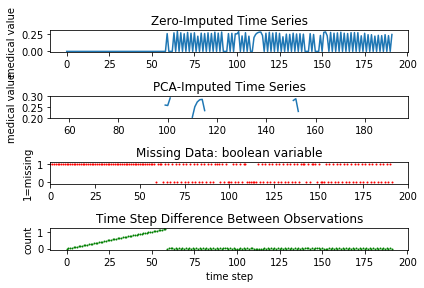

variable:  49


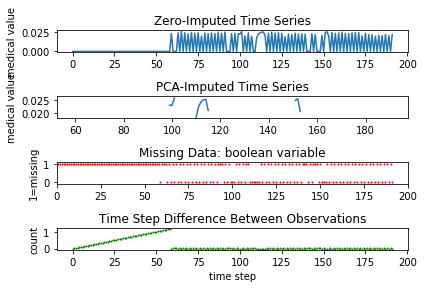

variable:  50


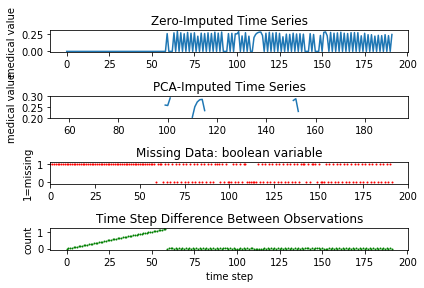

variable:  51


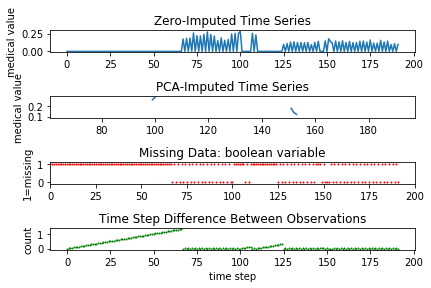

variable:  52


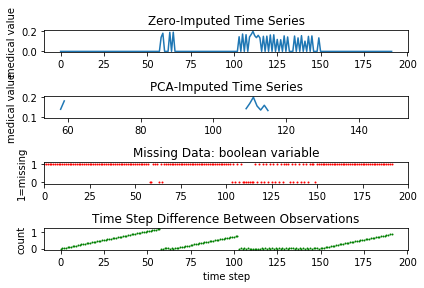

variable:  53


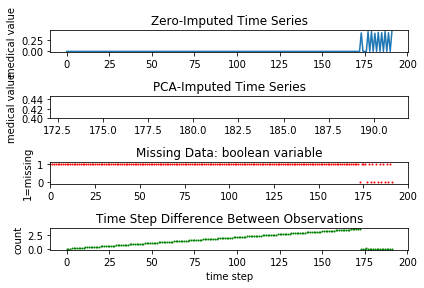

variable:  54


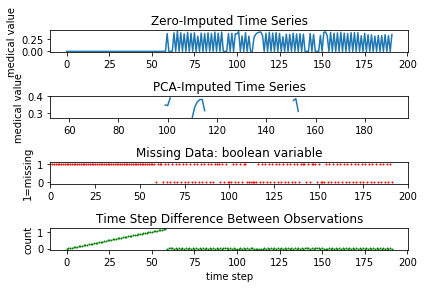

variable:  55


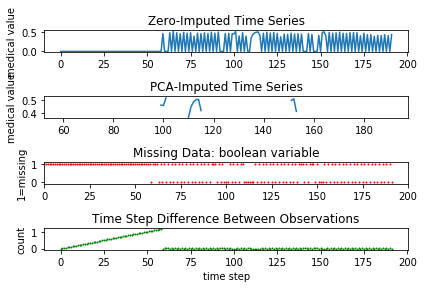

variable:  56


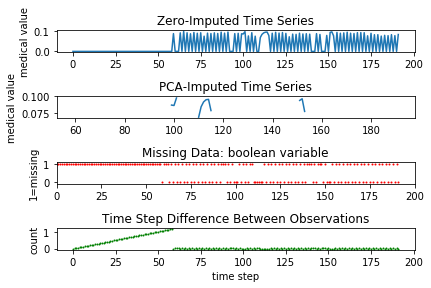

variable:  57


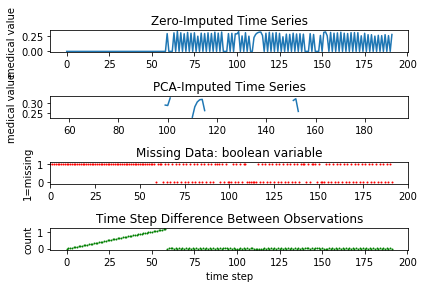

variable:  58


IndexError: index 58 is out of bounds for dimension 1 with size 58

In [71]:
plotPCAImputation(1, out1, out2, out3)

#timeseries for variables [0,11) union with (11,13] were imputed with zeros b/c there were too few patient observations
#time sereis for variable 11 was imputed using KNN b/c there was an observation